## Predicting Youtube Views

In [97]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u282-b08-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
* 2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2


In [101]:
import random
import numpy as np 
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
np.random.seed(545)

In [102]:
## If boto3 not already installed uncomment the following:
!pip3 install boto3

In [103]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))

!unzip /content/youtube_data.zip

Archive:  /content/youtube_data.zip
replace youtube_data/IN_category_id.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Machine Learning with Sklearn

## Data loading and Preprocessing

The dataset is a daily record of the top trending YouTube videos.This dataset includes several months of data on daily trending YouTube videos. Data is included for numerous countries, with up to 200 listed trending videos per day.

Each region’s data is in a separate file. Data includes:

*   Video Title
*   Channel title
*   Publish time
*   Tags
*   Views
*   Likes
*   Dislikes
*   Description
*   Comment count

The data also includes a category\_id field, which varies between regions. To retrieve the categories for a specific video, find it in the associated JSON. One such file is included for each of the five regions in the dataset.



In [104]:
files = [i for i in glob.glob('/content/youtube_data/*.csv'.format('csv'))]
sorted(files)

print(files[0][22:24])

country_list = {'CA': 'Canada', 'US': 'United States', 'FR': 'France', 'IN': 'India'}

IN


In [105]:
files

['/content/youtube_data/INvideos.csv',
 '/content/youtube_data/FRvideos.csv',
 '/content/youtube_data/USvideos.csv',
 '/content/youtube_data/CAvideos.csv']

In [106]:
# Import all the csv files
files = [i for i in glob.glob('/content/youtube_data/*.csv'.format('csv'))]
sorted(files)

all_dataframes = list()
country_list = {'CA': 'Canada', 'US': 'United States', 'FR': 'France', 'IN': 'India'}
for csv in files:
  country = country_list.get(csv[22:24])
  csv_df = pd.read_csv(csv)
  csv_df = csv_df.set_index('video_id')
  csv_df['country'] = country
  all_dataframes.append(csv_df)
  
combined_data = pd.concat(all_dataframes)

combined_data.head()

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
video_id,,,,,,,,,,,,,,,,
kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,India
zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",India
10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,India
N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...,India
kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...,India


In [108]:
category_id_df = pd.read_json('/content/youtube_data/US_category_id.json')

category_map = {}

for i in category_id_df['items']:
  id = i.get('id')
  title = i.get('snippet').get('title')
  category_map[id] = title

category_map

{'1': 'Film & Animation',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '2': 'Autos & Vehicles',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

In [109]:
combined_data['category_id'] = combined_data['category_id'].astype(str)

#Your code goes here

combined_data.insert(4, 'category', combined_data['category_id'].apply(lambda x: category_map.get(x)))


#### Fix datetime format and remove rows with NA's 

In [111]:
 combined_data['trending_date'][0][6:8] + '/' + combined_data['trending_date'][0][3:5] + '/' + combined_data['trending_date'][0][:2]

'11/14/17'

In [112]:


def reformat_date(date):
  ret_date = date[6:8] + '/' + date[3:5] + '/' + date[:2]
  return ret_date


combined_data['publish_time'] = pd.to_datetime(combined_data['publish_time'])

# Code to remove NA's
combined_data = combined_data.dropna()



## 1.2 EDA and Feature Engineering

In [114]:
# Your code goes here
maxs = [combined_data['views'].max(), combined_data['likes'].max(), combined_data['dislikes'].max(), combined_data['comment_count'].max()]
mins = [combined_data['views'].min(), combined_data['likes'].min(), combined_data['dislikes'].min(), combined_data['comment_count'].min()]
stds = [combined_data['views'].std(), combined_data['likes'].std(), combined_data['dislikes'].std(), combined_data['comment_count'].std()]
means = [combined_data['views'].mean(), combined_data['likes'].mean(), combined_data['dislikes'].mean(), combined_data['comment_count'].mean()]

print(maxs)
print(mins)
print(stds)
print(means)


[225211923, 5613827, 1643059, 1228655]
[223, 0, 0, 0]
[4605292.47838577, 152148.95485475217, 18258.541379660914, 23278.225620615463]
[1281578.03423758, 40961.05191276275, 2056.138490104615, 4606.593742519425]


#### Rescale features 

In [116]:
import math

# Your code goes here
combined_data['likes_log'] = combined_data['likes'].apply(lambda x: math.log(x+1))
combined_data['views_log'] = combined_data['views'].apply(lambda x: math.log(x+1))
combined_data['dislikes_log'] = combined_data['dislikes'].apply(lambda x: math.log(x+1))
combined_data['comment_log'] = combined_data['comment_count'].apply(lambda x: math.log(x+1))

In [118]:
combined_data[['likes_log', 'views_log', 'dislikes_log', 'comment_log']]

,likes_log,views_log,dislikes_log,comment_log
video_id,,,,
kzwfHumJyYc,10.433145,13.907477,6.683361,6.783325
zUZ1z7FwLc8,6.601230,13.288051,6.807935,0.000000
10L1hZ9qa58,7.606885,13.068939,5.497168,5.010635
N1vE8iiEg64,11.161295,14.032782,7.393263,7.895436
kJzGH0PVQHQ,6.200509,13.047674,5.683580,4.204693
...,...,...,...,...
sGolxsMSGfQ,7.439559,11.298320,4.605170,7.180070
8HNuRNi8t70,6.133398,11.545780,4.204693,3.951244
GWlKEM3m2EE,10.162037,13.558484,5.416100,8.264106


In [119]:
likes_log_sorted = combined_data['likes_log'].sort_values(ascending = True)
views_log_sorted = combined_data['views_log'].sort_values(ascending = True)
dislikes_log_sorted = combined_data['dislikes_log'].sort_values(ascending = True)
comment_log_sorted = combined_data['comment_log'].sort_values(ascending = True)

likes_log_sorted

video_id
ZnG5v1YB8wM     0.000000
WEW4DESwnF8     0.000000
fPj5M-sZHjc     0.000000
WO3wgDBPtkE     0.000000
RdMWIgZIPD8     0.000000
                 ...    
7C2z4GqqS5E    15.509109
7C2z4GqqS5E    15.517774
7C2z4GqqS5E    15.525801
7C2z4GqqS5E    15.537420
7C2z4GqqS5E    15.540743
Name: likes_log, Length: 154567, dtype: float64

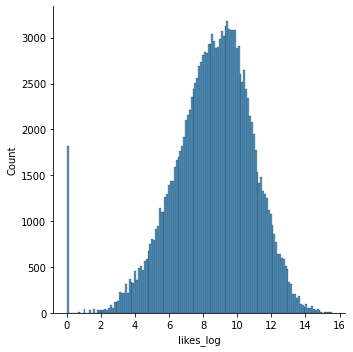

In [120]:
# Your code goes here
# Plots will be manually graded

sns.displot(data = likes_log_sorted)

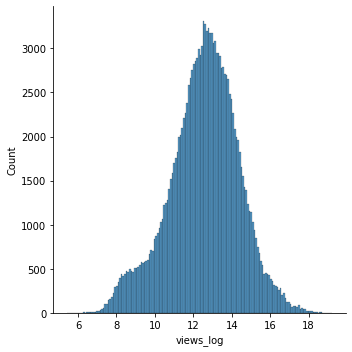

In [121]:
sns.displot(data = views_log_sorted)

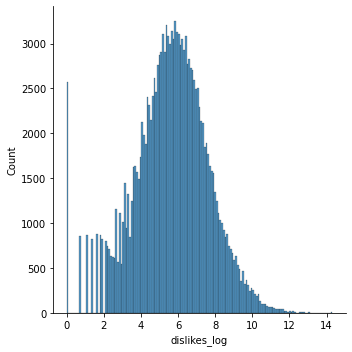

In [122]:
sns.displot(data = dislikes_log_sorted)

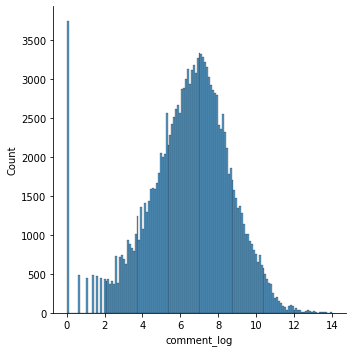

In [123]:
sns.displot(data = comment_log_sorted)

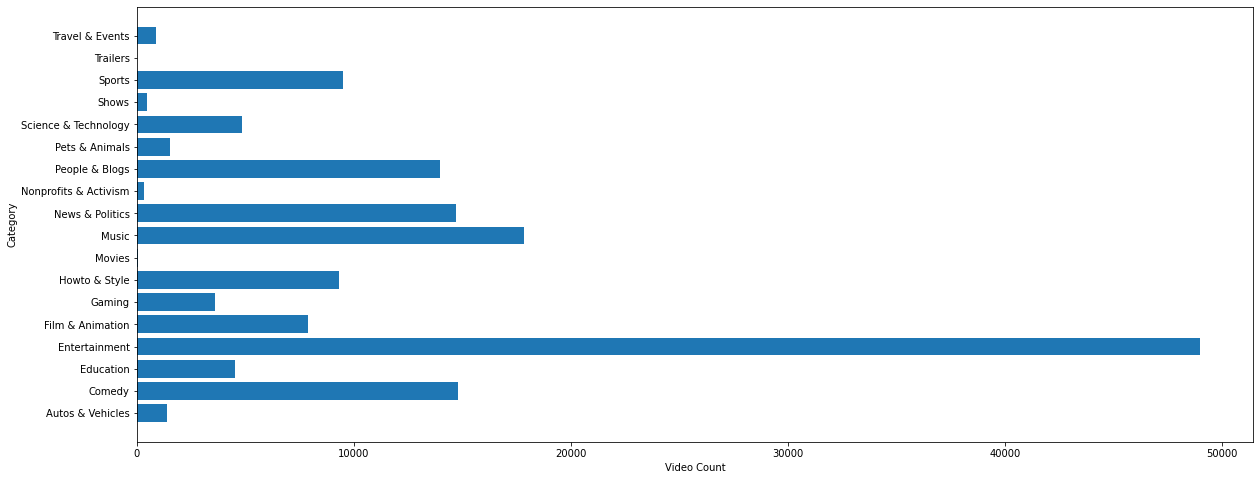

In [124]:
#1

video_count = combined_data.groupby(by = ['category']).count()
fig = plt.figure(figsize=(20,8)) 
plt.barh(video_count.index, video_count['title'])
plt.xlabel('Video Count')
plt.ylabel('Category')
plt.show()

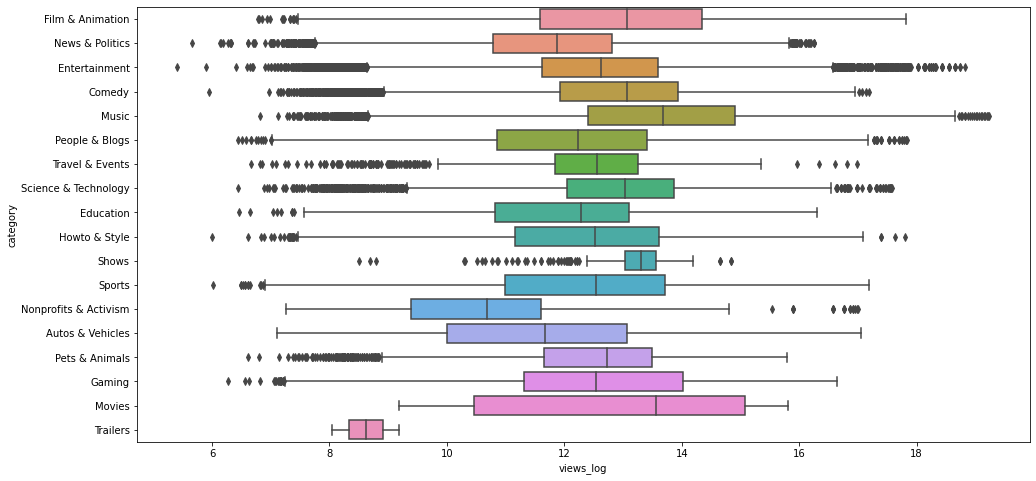

In [125]:
#2

fig, ax = plt.subplots(figsize = (16, 8))
sns.boxplot(x = "views_log", y = "category", data = combined_data, width = 0.8)

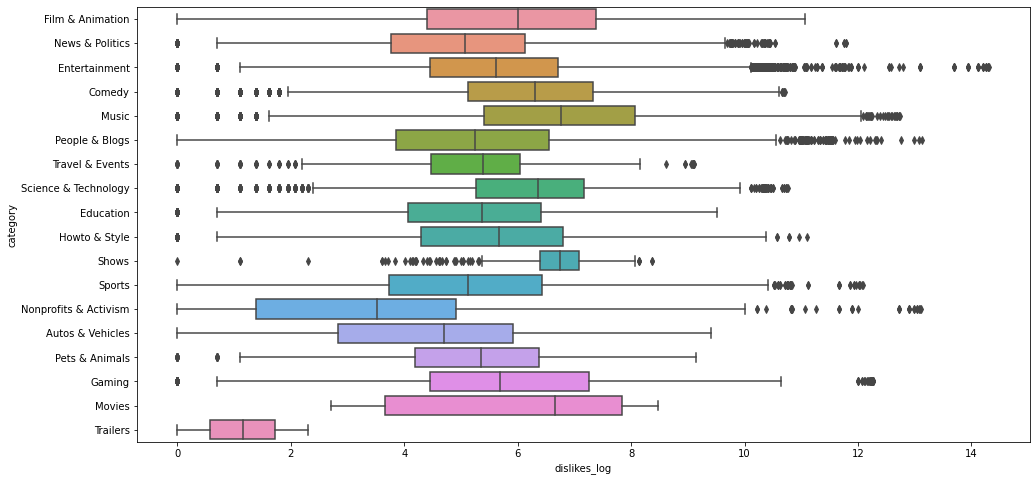

In [126]:
#3

fig, ax = plt.subplots(figsize = (16, 8))
sns.boxplot(x = "dislikes_log", y = "category", data = combined_data, width = 0.8)

#### Feature Engineering


In [127]:


combined_data["num_tags"]= combined_data['tags'].apply(lambda x: len(x.split("|")))

combined_data[['tags','num_tags']]

,tags,num_tags
video_id,,
kzwfHumJyYc,"sharry mann|""sharry mann new song""|""sharry man...",15
zUZ1z7FwLc8,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",19
10L1hZ9qa58,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,14
N1vE8iiEg64,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",20
kJzGH0PVQHQ,"Filmylooks|""latest news""|""telugu movies""|""telu...",11
...,...,...
sGolxsMSGfQ,"annoying orange|""funny""|""fruit""|""talking""|""ani...",21
8HNuRNi8t70,"hkayet tounsia|""elhiwar ettounsi""|""denya okhra...",35
GWlKEM3m2EE,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",18


In [128]:

combined_data["desc_len"]= combined_data["description"].apply(lambda x: len(x))

In [129]:

combined_data["len_title"]= combined_data["title"].apply(lambda x: len(x))

In [131]:
combined_data.head(5)

,trending_date,title,channel_title,category_id,category,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,likes_log,views_log,dislikes_log,comment_log,num_tags,desc_len,len_title
video_id,,,,,,,,,,,,,,,,,,,,,,,,
kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,Film & Animation,2017-11-12 12:20:39+00:00,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,India,10.433145,13.907477,6.683361,6.783325,15,920,81
zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,News & Politics,2017-11-13 05:43:56+00:00,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",India,6.601230,13.288051,6.807935,0.000000,19,2232,58
10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,Entertainment,2017-11-12 15:48:08+00:00,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,India,7.606885,13.068939,5.497168,5.010635,14,482,58
N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,Comedy,2017-11-12 07:08:48+00:00,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...,India,11.161295,14.032782,7.393263,7.895436,20,263,30
kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,Entertainment,2017-11-13 01:14:16+00:00,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...,India,6.200509,13.047674,5.683580,4.204693,11,753,88


In [132]:

combined_data_copy = combined_data.copy()
a = combined_data_copy['publish_time'].apply(lambda x: x.time())

In [133]:


combined_data['publish_time'] = combined_data_copy['publish_time'].apply(lambda x: x.time())
combined_data['publish_date'] = combined_data_copy['publish_time'].apply(lambda x: x.date())

#day on which video was published
combined_data['publish_weekday'] = combined_data_copy['publish_time'].apply(lambda x: x.weekday())

random_index = random.randint(0,combined_data.shape[0]-1)



In [135]:
day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
combined_data['publish_day'] = combined_data['publish_weekday'].apply(lambda x: day_dict.get(x))

combined_data.head(5)

,trending_date,title,channel_title,category_id,category,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,likes_log,views_log,dislikes_log,comment_log,num_tags,desc_len,len_title,publish_date,publish_weekday,publish_day
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,Film & Animation,12:20:39,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,India,10.433145,13.907477,6.683361,6.783325,15,920,81,2017-11-12,6,Sunday
zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,News & Politics,05:43:56,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",India,6.601230,13.288051,6.807935,0.000000,19,2232,58,2017-11-13,0,Monday
10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,Entertainment,15:48:08,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,India,7.606885,13.068939,5.497168,5.010635,14,482,58,2017-11-12,6,Sunday
N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,Comedy,07:08:48,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...,India,11.161295,14.032782,7.393263,7.895436,20,263,30,2017-11-12,6,Sunday
kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,Entertainment,01:14:16,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...,India,6.200509,13.047674,5.683580,4.204693,11,753,88,2017-11-13,0,Monday


In [136]:
day_count = combined_data.groupby(by = ['publish_weekday','publish_day']).count()
day_count['day'] = day_count.index
day_count['day'] = day_count['day'].apply(lambda x: x[1])
day_count['count'] = day_count['title']

day_count

,,trending_date,title,channel_title,category_id,category,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,likes_log,views_log,dislikes_log,comment_log,num_tags,desc_len,len_title,publish_date,day,count
publish_weekday,publish_day,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Monday,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,22146,Monday,22146
1,Tuesday,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,22501,Tuesday,22501
2,Wednesday,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,22523,Wednesday,22523
3,Thursday,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,23573,Thursday,23573
4,Friday,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,26252,Friday,26252
5,Saturday,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,18931,Saturday,18931
6,Sunday,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,18641,Sunday,18641


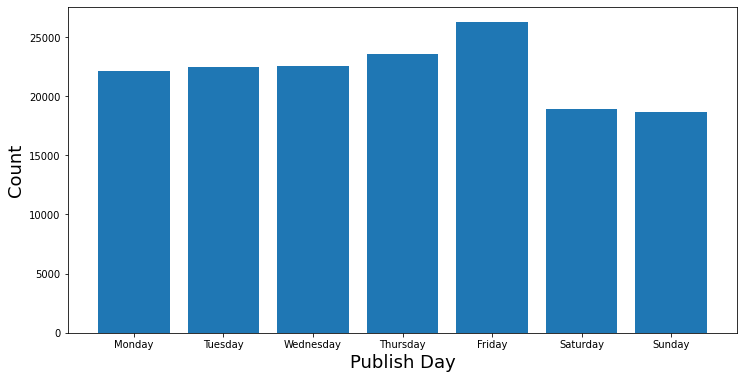

In [137]:


fig = plt.figure(figsize=(12,6)) 
plt.bar(day_count['day'], day_count['count'])
plt.xlabel('Publish Day', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.show()

In [138]:
combined_data.head(5)

,trending_date,title,channel_title,category_id,category,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,likes_log,views_log,dislikes_log,comment_log,num_tags,desc_len,len_title,publish_date,publish_weekday,publish_day
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,Film & Animation,12:20:39,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,India,10.433145,13.907477,6.683361,6.783325,15,920,81,2017-11-12,6,Sunday
zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,News & Politics,05:43:56,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",India,6.601230,13.288051,6.807935,0.000000,19,2232,58,2017-11-13,0,Monday
10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,Entertainment,15:48:08,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,India,7.606885,13.068939,5.497168,5.010635,14,482,58,2017-11-12,6,Sunday
N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,Comedy,07:08:48,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...,India,11.161295,14.032782,7.393263,7.895436,20,263,30,2017-11-12,6,Sunday
kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,Entertainment,01:14:16,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...,India,6.200509,13.047674,5.683580,4.204693,11,753,88,2017-11-13,0,Monday


In [139]:
#storing copy of combined data
combined_data_copy = combined_data.copy()

In [140]:
combined_data = combined_data.drop(['title', 'channel_title', 'category', 'tags', 'thumbnail_link','description','publish_day'], axis = 1)
combined_data = combined_data.drop(['views', 'likes', 'dislikes', 'comment_count'], axis = 1)

In [141]:
combined_data = combined_data.drop(['trending_date'], axis =1)


In [142]:
combined_data = combined_data.drop(['publish_date'], axis = 1)

In [143]:
combined_data = combined_data.drop(['publish_time'], axis = 1)

In [144]:


combined_data.head(5)


,category_id,comments_disabled,ratings_disabled,video_error_or_removed,country,likes_log,views_log,dislikes_log,comment_log,num_tags,desc_len,len_title,publish_weekday
video_id,,,,,,,,,,,,,
kzwfHumJyYc,1,False,False,False,India,10.433145,13.907477,6.683361,6.783325,15,920,81,6
zUZ1z7FwLc8,25,True,False,False,India,6.601230,13.288051,6.807935,0.000000,19,2232,58,0
10L1hZ9qa58,24,False,False,False,India,7.606885,13.068939,5.497168,5.010635,14,482,58,6
N1vE8iiEg64,23,False,False,False,India,11.161295,14.032782,7.393263,7.895436,20,263,30,6
kJzGH0PVQHQ,24,False,False,False,India,6.200509,13.047674,5.683580,4.204693,11,753,88,0


In [145]:

combined_data.shape

(154567, 13)

####  Convert categorical features in the dataset into one hot vectors.



In [146]:
combined_data_copy = combined_data.copy().reset_index()

In [147]:
one_hot_category_id = pd.get_dummies(combined_data_copy['category_id'])

one_hot_category_id

,1,10,15,17,19,2,20,22,23,24,25,26,27,28,29,30,43,44
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154562,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
154563,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
154564,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
154565,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [148]:
one_hot_country = pd.get_dummies(combined_data_copy['country'])

one_hot_country

,Canada,France,India,United States
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
154562,1,0,0,0
154563,1,0,0,0
154564,1,0,0,0
154565,1,0,0,0


In [149]:
one_hot_publish_weekday = pd.get_dummies(combined_data_copy['publish_weekday'])

one_hot_publish_weekday

,0,1,2,3,4,5,6
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
154562,0,0,1,0,0,0,0
154563,0,0,1,0,0,0,0
154564,1,0,0,0,0,0,0
154565,0,0,1,0,0,0,0


In [150]:
df = combined_data_copy.join(one_hot_category_id).join(one_hot_country).join(one_hot_publish_weekday)
df = df.drop(['category_id', 'country','publish_weekday'], axis = 1)
df = df.set_index('video_id')

df

,comments_disabled,ratings_disabled,video_error_or_removed,likes_log,views_log,dislikes_log,comment_log,num_tags,desc_len,len_title,1,10,15,17,19,2,20,22,23,24,25,26,27,28,29,30,43,44,Canada,France,India,United States,0,1,2,3,4,5,6
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
kzwfHumJyYc,False,False,False,10.433145,13.907477,6.683361,6.783325,15,920,81,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
zUZ1z7FwLc8,True,False,False,6.601230,13.288051,6.807935,0.000000,19,2232,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
10L1hZ9qa58,False,False,False,7.606885,13.068939,5.497168,5.010635,14,482,58,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
N1vE8iiEg64,False,False,False,11.161295,14.032782,7.393263,7.895436,20,263,30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
kJzGH0PVQHQ,False,False,False,6.200509,13.047674,5.683580,4.204693,11,753,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sGolxsMSGfQ,False,False,False,7.439559,11.298320,4.605170,7.180070,21,502,28,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
8HNuRNi8t70,False,False,False,6.133398,11.545780,4.204693,3.951244,35,213,32,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
GWlKEM3m2EE,False,False,False,10.162037,13.558484,5.416100,8.264106,18,763,57,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [151]:

combined_data.publish_weekday = combined_data.publish_weekday.astype('category')
combined_data.country = combined_data.country.astype('category')

# Hint: Use pd.get_dummies()range. 

combined_data = df

#combined_data


In [153]:
combined_data_sec_2 = combined_data.copy()
combined_data_sec_2.rename(columns = {'views_log':'label'}, inplace = True) 
combined_data_sec_2.to_csv('combined_data.csv')

In [154]:
combined_data_sec_2

,comments_disabled,ratings_disabled,video_error_or_removed,likes_log,label,dislikes_log,comment_log,num_tags,desc_len,len_title,1,10,15,17,19,2,20,22,23,24,25,26,27,28,29,30,43,44,Canada,France,India,United States,0,1,2,3,4,5,6
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
kzwfHumJyYc,False,False,False,10.433145,13.907477,6.683361,6.783325,15,920,81,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
zUZ1z7FwLc8,True,False,False,6.601230,13.288051,6.807935,0.000000,19,2232,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
10L1hZ9qa58,False,False,False,7.606885,13.068939,5.497168,5.010635,14,482,58,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
N1vE8iiEg64,False,False,False,11.161295,14.032782,7.393263,7.895436,20,263,30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
kJzGH0PVQHQ,False,False,False,6.200509,13.047674,5.683580,4.204693,11,753,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sGolxsMSGfQ,False,False,False,7.439559,11.298320,4.605170,7.180070,21,502,28,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
8HNuRNi8t70,False,False,False,6.133398,11.545780,4.204693,3.951244,35,213,32,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
GWlKEM3m2EE,False,False,False,10.162037,13.558484,5.416100,8.264106,18,763,57,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [155]:
# Your code goes here
label = combined_data_sec_2['label']
features = combined_data_sec_2.drop(['label'], axis = 1)

### Split data into train and test 

 the split is 80-20.


In [157]:
from sklearn.model_selection import train_test_split
# Your code goes here

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.20)


### 1.3.2: Train Machine Learning Models.

#### 1.3.2.1 Linear Regression (3 pts)

In this step we will train a linear regression model using sklearn. Train using the training data and then make predictions of test, report the mean squared error obtained on both train and test sets.

In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [160]:
regr = LinearRegression()
regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)

In [161]:
y_pred

array([ 9.71846353, 14.22050463, 14.33245054, ..., 13.53155827,
       15.78400574, 13.11648574])

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Your code goes here

mse_test = mean_squared_error(y_test, y_pred)

### Dimensionality reduction with PCA 


##### Fitting PCA and explained_variance_ratiio


In [164]:
import numpy as np
from sklearn.decomposition import PCA


In [165]:
np.set_printoptions(suppress = True)
pca = PCA(n_components = 38)

In [166]:
x2 = pca.fit_transform(x_train)

##### Deciding number of components to keep


In [167]:
evr = pca.explained_variance_ratio_

evr

array([0.99908585, 0.00071705, 0.00017553, 0.00001606, 0.00000143,
       0.0000009 , 0.00000036, 0.00000032, 0.00000029, 0.00000025,
       0.00000023, 0.0000002 , 0.0000002 , 0.0000002 , 0.00000017,
       0.00000016, 0.00000014, 0.00000012, 0.00000011, 0.00000009,
       0.00000008, 0.00000007, 0.00000005, 0.00000004, 0.00000003,
       0.00000002, 0.00000001, 0.00000001, 0.00000001, 0.00000001,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [168]:
dict = {0:0}

i = 1
for r in evr:
  dict[i] = r + dict[i-1]
  i += 1

dict

{0: 0,
 1: 0.9990858520147764,
 2: 0.9998029022492156,
 3: 0.9999784292647085,
 4: 0.9999944849557643,
 5: 0.999995910145066,
 6: 0.9999968081454014,
 7: 0.9999971712725637,
 8: 0.9999974884908835,
 9: 0.9999977797124978,
 10: 0.999998031151986,
 11: 0.9999982569696183,
 12: 0.9999984619138186,
 13: 0.9999986600876465,
 14: 0.9999988563586227,
 15: 0.9999990296223521,
 16: 0.9999991941783886,
 17: 0.9999993304993512,
 18: 0.9999994536951571,
 19: 0.9999995629952473,
 20: 0.9999996543671427,
 21: 0.9999997328027543,
 22: 0.9999998051408634,
 23: 0.9999998523824718,
 24: 0.9999998932899483,
 25: 0.9999999259318537,
 26: 0.9999999495619167,
 27: 0.9999999643474828,
 28: 0.9999999769666953,
 29: 0.9999999851122224,
 30: 0.9999999911664227,
 31: 0.9999999957999637,
 32: 0.9999999988946386,
 33: 0.9999999996614587,
 34: 0.9999999999767204,
 35: 1.0000000000000002,
 36: 1.0000000000000002,
 37: 1.0000000000000002,
 38: 1.0000000000000002}

In [169]:

pca = PCA(n_components = 1)
x_train = pca.fit_transform(x_train)

In [170]:
x_train

array([[ 419.73345404],
       [  35.57261305],
       [ 665.59929592],
       ...,
       [-835.40004825],
       [-664.34254369],
       [-816.43451757]])

### Random Forest. 



#####  Hyperparameter tuning. 


In [173]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Only tune the max depth of the trees in the RF hyperparameter.

depth = [15]
nEstimator = [140]

GS_object = GridSearchCV(estimator= RandomForestRegressor(), param_grid = {'n_estimators': nEstimator, 'max_depth': depth})
GS_object.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [174]:
GS_object.best_params_

{'max_depth': 15, 'n_estimators': 140}

#####  Fitting RF


In [175]:


rf = RandomForestRegressor(n_estimators = 140, max_depth = GS_object.best_params_.get('max_depth'))
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Spark

### Initializing Spark Connection


In [96]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 30 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkadm5srv-mit11 amd64 1.16-2ubuntu0.2 [49.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkadm5

     |████████████████████████████████| 212.3MB 42kB/s 
     |████████████████████████████████| 204kB 16.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=61df97b17a1365229134ec3e8673f544b1d87e2aea784769621bdb6a64b14e2d
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [177]:
!apt update
!apt install gcc python-dev libkrb5-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://ppa

In [178]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()


In [179]:
%load_ext sparkmagic.magics

In [180]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [181]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


In [182]:
df = pd.read_csv('/content/combined_data.csv')
df

,video_id,comments_disabled,ratings_disabled,video_error_or_removed,likes_log,label,dislikes_log,comment_log,num_tags,desc_len,len_title,1,10,15,17,19,2,20,22,23,24,25,26,27,28,29,30,43,44,Canada,France,India,United States,0,1.1,2.1,3,4,5,6
0,kzwfHumJyYc,False,False,False,10.433145,13.907477,6.683361,6.783325,15,920,81,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,zUZ1z7FwLc8,True,False,False,6.601230,13.288051,6.807935,0.000000,19,2232,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,10L1hZ9qa58,False,False,False,7.606885,13.068939,5.497168,5.010635,14,482,58,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,N1vE8iiEg64,False,False,False,11.161295,14.032782,7.393263,7.895436,20,263,30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,kJzGH0PVQHQ,False,False,False,6.200509,13.047674,5.683580,4.204693,11,753,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154562,sGolxsMSGfQ,False,False,False,7.439559,11.298320,4.605170,7.180070,21,502,28,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
154563,8HNuRNi8t70,False,False,False,6.133398,11.545780,4.204693,3.951244,35,213,32,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
154564,GWlKEM3m2EE,False,False,False,10.162037,13.558484,5.416100,8.264106,18,763,57,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
154565,lbMKLzQ4cNQ,False,False,False,7.657283,11.654651,5.209486,7.422374,36,1785,32,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [183]:
combined_data_sec_2

,comments_disabled,ratings_disabled,video_error_or_removed,likes_log,label,dislikes_log,comment_log,num_tags,desc_len,len_title,1,10,15,17,19,2,20,22,23,24,25,26,27,28,29,30,43,44,Canada,France,India,United States,0,1,2,3,4,5,6
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
kzwfHumJyYc,False,False,False,10.433145,13.907477,6.683361,6.783325,15,920,81,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
zUZ1z7FwLc8,True,False,False,6.601230,13.288051,6.807935,0.000000,19,2232,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
10L1hZ9qa58,False,False,False,7.606885,13.068939,5.497168,5.010635,14,482,58,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
N1vE8iiEg64,False,False,False,11.161295,14.032782,7.393263,7.895436,20,263,30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
kJzGH0PVQHQ,False,False,False,6.200509,13.047674,5.683580,4.204693,11,753,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sGolxsMSGfQ,False,False,False,7.439559,11.298320,4.605170,7.180070,21,502,28,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
8HNuRNi8t70,False,False,False,6.133398,11.545780,4.204693,3.951244,35,213,32,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
GWlKEM3m2EE,False,False,False,10.162037,13.558484,5.416100,8.264106,18,763,57,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [184]:

spark_reader = spark.read

train_sdf = spark_reader.load('/content/combined_data.csv', format = 'csv', inferSchema = True, header = True)

In [185]:
train_sdf.dtypes

[('video_id', 'string'),
 ('comments_disabled', 'boolean'),
 ('ratings_disabled', 'boolean'),
 ('video_error_or_removed', 'boolean'),
 ('likes_log', 'double'),
 ('label', 'double'),
 ('dislikes_log', 'double'),
 ('comment_log', 'double'),
 ('num_tags', 'int'),
 ('desc_len', 'int'),
 ('len_title', 'int'),
 ('111', 'int'),
 ('10', 'int'),
 ('15', 'int'),
 ('17', 'int'),
 ('19', 'int'),
 ('216', 'int'),
 ('20', 'int'),
 ('22', 'int'),
 ('23', 'int'),
 ('24', 'int'),
 ('25', 'int'),
 ('26', 'int'),
 ('27', 'int'),
 ('28', 'int'),
 ('29', 'int'),
 ('30', 'int'),
 ('43', 'int'),
 ('44', 'int'),
 ('Canada', 'int'),
 ('France', 'int'),
 ('India', 'int'),
 ('United States', 'int'),
 ('0', 'int'),
 ('134', 'int'),
 ('235', 'int'),
 ('3', 'int'),
 ('4', 'int'),
 ('5', 'int'),
 ('6', 'int')]

In [186]:
#rename some of the columns 

train_sdf = train_sdf.withColumnRenamed('111','category_id_1')
train_sdf = train_sdf.withColumnRenamed('216','category_id_2')
train_sdf = train_sdf.withColumnRenamed('10','category_id_10')
train_sdf = train_sdf.withColumnRenamed('15','category_id_15')
train_sdf = train_sdf.withColumnRenamed('17','category_id_17')
train_sdf = train_sdf.withColumnRenamed('19','category_id_19')
train_sdf = train_sdf.withColumnRenamed('20','category_id_20')
train_sdf = train_sdf.withColumnRenamed('22','category_id_22')
train_sdf = train_sdf.withColumnRenamed('23','category_id_23')
train_sdf = train_sdf.withColumnRenamed('24','category_id_24')
train_sdf = train_sdf.withColumnRenamed('25','category_id_25')
train_sdf = train_sdf.withColumnRenamed('26','category_id_26')
train_sdf = train_sdf.withColumnRenamed('27','category_id_27')
train_sdf = train_sdf.withColumnRenamed('28','category_id_28')
train_sdf = train_sdf.withColumnRenamed('29','category_id_29')
train_sdf = train_sdf.withColumnRenamed('30','category_id_30')
train_sdf = train_sdf.withColumnRenamed('43','category_id_43')
train_sdf = train_sdf.withColumnRenamed('44','category_id_44')

train_sdf = train_sdf.withColumnRenamed('Canada','country_CA')
train_sdf = train_sdf.withColumnRenamed('France','country_FR')
train_sdf = train_sdf.withColumnRenamed('India','country_IN')
train_sdf = train_sdf.withColumnRenamed('United States','country_US')

train_sdf = train_sdf.withColumnRenamed('0','publish_weekday_0')
train_sdf = train_sdf.withColumnRenamed('134','publish_weekday_1')
train_sdf = train_sdf.withColumnRenamed('235', 'publish_weekday_2')
train_sdf = train_sdf.withColumnRenamed('3','publish_weekday_3')
train_sdf = train_sdf.withColumnRenamed('4','publish_weekday_4')
train_sdf = train_sdf.withColumnRenamed('5','publish_weekday_5')
train_sdf = train_sdf.withColumnRenamed('6','publish_weekday_6')

train_sdf.dtypes

[('video_id', 'string'),
 ('comments_disabled', 'boolean'),
 ('ratings_disabled', 'boolean'),
 ('video_error_or_removed', 'boolean'),
 ('likes_log', 'double'),
 ('label', 'double'),
 ('dislikes_log', 'double'),
 ('comment_log', 'double'),
 ('num_tags', 'int'),
 ('desc_len', 'int'),
 ('len_title', 'int'),
 ('category_id_1', 'int'),
 ('category_id_10', 'int'),
 ('category_id_15', 'int'),
 ('category_id_17', 'int'),
 ('category_id_19', 'int'),
 ('category_id_2', 'int'),
 ('category_id_20', 'int'),
 ('category_id_22', 'int'),
 ('category_id_23', 'int'),
 ('category_id_24', 'int'),
 ('category_id_25', 'int'),
 ('category_id_26', 'int'),
 ('category_id_27', 'int'),
 ('category_id_28', 'int'),
 ('category_id_29', 'int'),
 ('category_id_30', 'int'),
 ('category_id_43', 'int'),
 ('category_id_44', 'int'),
 ('country_CA', 'int'),
 ('country_FR', 'int'),
 ('country_IN', 'int'),
 ('country_US', 'int'),
 ('publish_weekday_0', 'int'),
 ('publish_weekday_1', 'int'),
 ('publish_weekday_2', 'int'),
 ('

Print out the dataframe schema and verify the datatypes

In [188]:


train_sdf.dtypes
train_sdf.columns

['video_id',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'likes_log',
 'label',
 'dislikes_log',
 'comment_log',
 'num_tags',
 'desc_len',
 'len_title',
 'category_id_1',
 'category_id_10',
 'category_id_15',
 'category_id_17',
 'category_id_19',
 'category_id_2',
 'category_id_20',
 'category_id_22',
 'category_id_23',
 'category_id_24',
 'category_id_25',
 'category_id_26',
 'category_id_27',
 'category_id_28',
 'category_id_29',
 'category_id_30',
 'category_id_43',
 'category_id_44',
 'country_CA',
 'country_FR',
 'country_IN',
 'country_US',
 'publish_weekday_0',
 'publish_weekday_1',
 'publish_weekday_2',
 'publish_weekday_3',
 'publish_weekday_4',
 'publish_weekday_5',
 'publish_weekday_6']

In [189]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [190]:

all_columns = train_sdf.columns

In [191]:

drop_columns = ['video_id', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'num_tags', 'desc_len', 'len_title']

In [192]:
columns_to_use = [i for i in all_columns if i not in drop_columns]

In [193]:

assembler = VectorAssembler(inputCols = columns_to_use, outputCol = 'features')

In [195]:
from pyspark.ml import Pipeline



pipeline = Pipeline(stages=[assembler])
model = pipeline.fit(train_sdf)
modified_data_sdf = model.transform(train_sdf)

Now that we have the data in the format we need, we will create out train and test sets. Split into an 80-20 ratio between the train and test sets. Name these 'train_sdf' and 'test_sdf'

In [197]:


train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2])

###Linear regression using Spark ML


In [199]:
features = []
for i in columns_to_use:
  if i != 'label':
    features.append(i)

features

['likes_log',
 'dislikes_log',
 'comment_log',
 'category_id_1',
 'category_id_10',
 'category_id_15',
 'category_id_17',
 'category_id_19',
 'category_id_2',
 'category_id_20',
 'category_id_22',
 'category_id_23',
 'category_id_24',
 'category_id_25',
 'category_id_26',
 'category_id_27',
 'category_id_28',
 'category_id_29',
 'category_id_30',
 'category_id_43',
 'category_id_44',
 'country_CA',
 'country_FR',
 'country_IN',
 'country_US',
 'publish_weekday_0',
 'publish_weekday_1',
 'publish_weekday_2',
 'publish_weekday_3',
 'publish_weekday_4',
 'publish_weekday_5',
 'publish_weekday_6']

In [200]:
train_sdf.show()

+--------+-----------------+----------------+----------------------+------------------+------------------+------------------+------------------+--------+--------+---------+-------------+--------------+--------------+--------------+--------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+----------+----------+----------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+
|video_id|comments_disabled|ratings_disabled|video_error_or_removed|         likes_log|             label|      dislikes_log|       comment_log|num_tags|desc_len|len_title|category_id_1|category_id_10|category_id_15|category_id_17|category_id_19|category_id_2|category_id_20|category_id_22|category_id_23|category_id_24|category_id_25|category_id_26|category_id_27|cat

In [201]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol = 'label',maxIter=10, regParam=0.0, elasticNetParam=0.0)
lr_model = lr.fit(train_sdf)

In [202]:
trainingSummary = lr_model.summary

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.009366
r2: 0.999973


In [204]:

predictions = lr_model.transform(test_sdf)

predictions.show()

+--------+-----------------+----------------+----------------------+-----------------+------------------+------------------+------------------+--------+--------+---------+-------------+--------------+--------------+--------------+--------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+----------+----------+----------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+------------------+
|video_id|comments_disabled|ratings_disabled|video_error_or_removed|        likes_log|             label|      dislikes_log|       comment_log|num_tags|desc_len|len_title|category_id_1|category_id_10|category_id_15|category_id_17|category_id_19|category_id_2|category_id_20|category_id_22|category_id_23|category_id_24|category_id_25|category_id_26|c

In [205]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
test_rmse_orig = evaluator.evaluate(predictions)

test_rmse_orig

0.009316223870435403

In [207]:
l1 = LinearRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, regParam=0.3, elasticNetParam=1)
l2 = LinearRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, regParam=0.2, elasticNetParam=0)
en = LinearRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, regParam=0.3, elasticNetParam=0)

l1_model = l1.fit(train_sdf)
l2_model = l2.fit(train_sdf)
en_model = en.fit(train_sdf)

In [208]:
l1_predictions = l1_model.transform(test_sdf)
l2_predictions = l2_model.transform(test_sdf)
elastic_net_predictions = en_model.transform(test_sdf)


test_rmse_l1 = evaluator.evaluate(l1_predictions)
test_rmse_l2 = evaluator.evaluate(l2_predictions)
test_rmse_elastic = evaluator.evaluate(elastic_net_predictions)


### Random Forest Regression

In [210]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features")
rf_model = rf.fit(train_sdf)


In [211]:
predictions = rf_model.transform(test_sdf)

In [212]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

train_rmse_rf = trainingSummary.rootMeanSquaredError
rmse_rf = evaluator.evaluate(predictions)

train_rmse_rf

0.009365657269111486

### Dimensionality Reduction using PCA 





In [214]:
train_sdf.show()

+--------+-----------------+----------------+----------------------+------------------+------------------+------------------+------------------+--------+--------+---------+-------------+--------------+--------------+--------------+--------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+----------+----------+----------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+
|video_id|comments_disabled|ratings_disabled|video_error_or_removed|         likes_log|             label|      dislikes_log|       comment_log|num_tags|desc_len|len_title|category_id_1|category_id_10|category_id_15|category_id_17|category_id_19|category_id_2|category_id_20|category_id_22|category_id_23|category_id_24|category_id_25|category_id_26|category_id_27|cat

In [215]:
from pyspark.ml.feature import PCA

pca = PCA(k=1, inputCol="features", outputCol="pcaFeatures")

In [216]:
pca_model = pca.fit(train_sdf)

In [217]:
pca_train_sdf = pca_model.transform(train_sdf)
pca_test_sdf = pca_model.transform(test_sdf)

lr = LinearRegression(featuresCol = 'pcaFeatures', labelCol = 'label',maxIter=10, regParam=0.0, elasticNetParam=0.0)
lr_model = lr.fit(pca_train_sdf)
predictions = lr_model.transform(pca_test_sdf)

training_rmse_pca = lr_model.summary.rootMeanSquaredError
test_rmse_pca = evaluator.evaluate(predictions)


In [ ]:

predictions_to_grade = predictions.toPandas()
answer = [training_rmse_pca, predictions_to_grade['prediction'][0:50], predictions_to_grade['label'][0:50], test_rmse_pca]
grader.grade('check_pca_spark', answer)